In [1]:
!pip install -qU crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

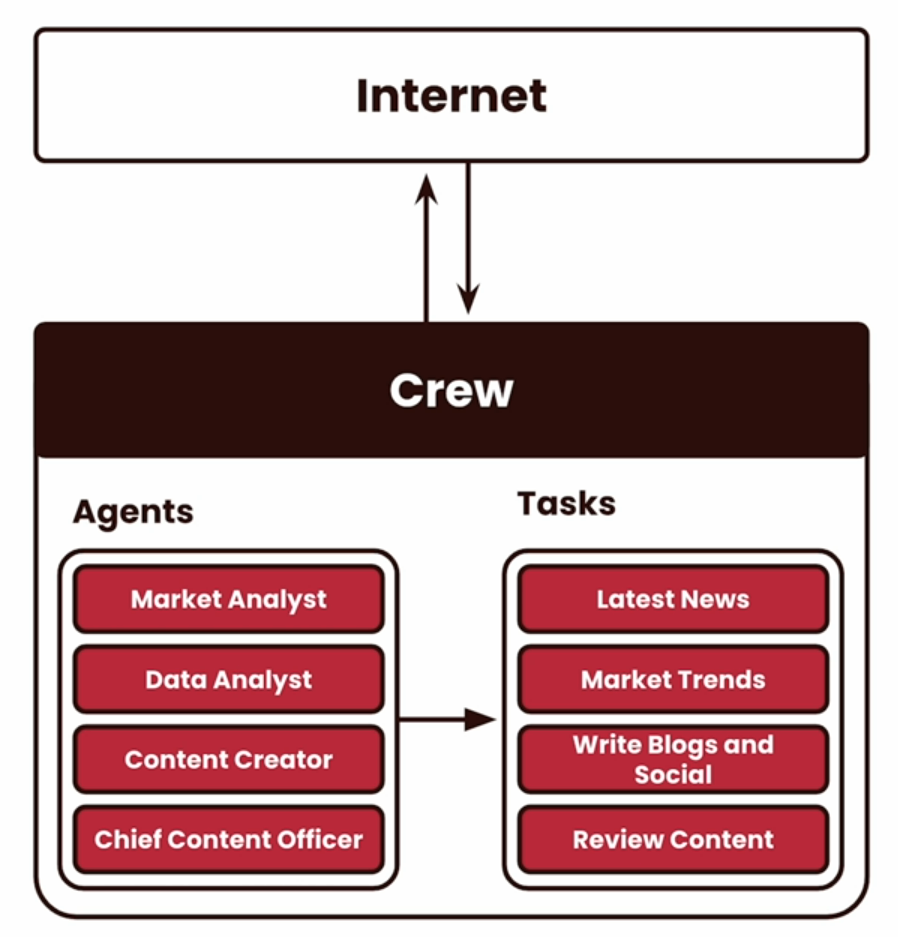

## Initial Imports

In [2]:
import os
import yaml
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:777: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `CrewAgentExecutor` to V2.
  warn(


In [3]:
# import os
# from utils import get_openai_api_key

# openai_api_key = get_openai_api_key()
# os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'


bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

## Creating Structured Output

In [4]:
from pydantic import BaseModel, Field
from typing import List

class SocialMediaPost(BaseModel):
    platform: str = Field(..., description="The social media platform where the post will be published (e.g., Twitter, LinkedIn).")
    content: str = Field(..., description="The content of the social media post, including any hashtags or mentions.")

class ContentOutput(BaseModel):
    article: str = Field(..., description="The article, formatted in markdown.")
    social_media_posts: List[SocialMediaPost] = Field(..., description="A list of social media posts related to the article.")

## Loading Tasks and Agents YAML files

In [5]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

## Importing CrewAI Tools

In [6]:
from crewai_tools import SerperDevTool, ScrapeWebsiteTool, WebsiteSearchTool

## Creating Crew, Agents, and Tasks

In [7]:
# Creating Agents
market_news_monitor_agent = Agent(
    config=agents_config['market_news_monitor_agent'],
    llm=llm,
    max_iter=5,
    memory=True,
    tools=[SerperDevTool(), ScrapeWebsiteTool()],
    
)

data_analyst_agent = Agent(
    config=agents_config['data_analyst_agent'],
    llm=llm,
    max_iter=5,
    memory=True,
    tools=[SerperDevTool(), WebsiteSearchTool()],
    
)

content_creator_agent = Agent(
    config=agents_config['content_creator_agent'],
    llm=llm,
    max_iter=5,
    memory=True,
    tools=[SerperDevTool(), WebsiteSearchTool()],
    
)

quality_assurance_agent = Agent(
    config=agents_config['quality_assurance_agent'],
    llm=llm,
    max_iter=5,
    memory=True,
    
)



# Creating Tasks
monitor_financial_news_task = Task(
    config=tasks_config['monitor_financial_news'],
    agent=market_news_monitor_agent
)

analyze_market_data_task = Task(
    config=tasks_config['analyze_market_data'],
    agent=data_analyst_agent
)

create_content_task = Task(
    config=tasks_config['create_content'],
    agent=content_creator_agent,
    context=[monitor_financial_news_task, analyze_market_data_task]
)

quality_assurance_task = Task(
    config=tasks_config['quality_assurance'],
    agent=quality_assurance_agent,
    output_pydantic=ContentOutput
)

# Creating Crew
content_creation_crew = Crew(
    agents=[
        market_news_monitor_agent,
        data_analyst_agent,
        content_creator_agent,
        quality_assurance_agent
    ],
    tasks=[
        monitor_financial_news_task,
        analyze_market_data_task,
        create_content_task,
        quality_assurance_task
    ],
    verbose=True
)

KeyError: 'OPENAI_API_KEY'

## Kicking off the Crew

In [ ]:
result = content_creation_crew.kickoff(inputs={
  'subject': 'Inflation in the US and the impact on the stock market in 2024'
})

## Social Content

In [8]:
import textwrap

posts = result.pydantic.dict()['social_media_posts']
for post in posts:
    platform = post['platform']
    content = post['content']
    print(platform)
    wrapped_content = textwrap.fill(content, width=50)
    print(wrapped_content)
    print('-' * 50)

NameError: name 'result' is not defined

## Blog Post

In [9]:
from IPython.display import display, Markdown
display(Markdown(result.pydantic.dict()['article']))

NameError: name 'result' is not defined